In [46]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy

from sklearn.model_selection import train_test_split

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'1.14.0'

In [47]:
# importing files
import zipfile
with zipfile.ZipFile('./trafficsigns_shapedata.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [48]:
from PIL import Image
import glob
image_list = []
for filepath in glob.glob('./trafficsigns_shapedata/*/*.png', recursive=True): #assuming gif
    filename = filepath.split("/")[-1]
    label = filepath.split("/")[-2]
    image_list.append((filepath, label))
    
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'label'])

In [49]:
data.label.unique()

array(['square', 'diamond', 'hex', 'triangle', 'round'], dtype=object)

In [50]:
data.shape

(3650, 2)

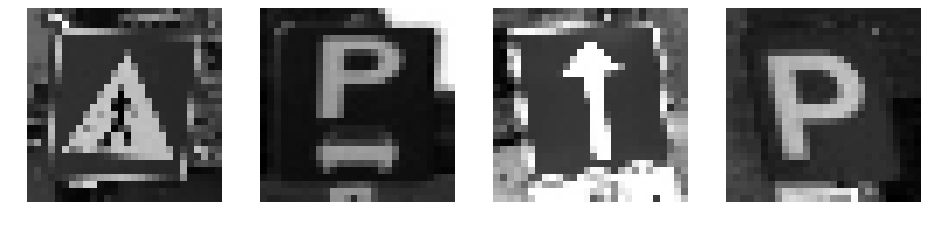

In [51]:
r_inx = np.random.choice(100, 4)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

In [52]:
d = {'square':0, 'diamond':1, 'hex':2, 'triangle':3, 'round':4}
data['labels_num'] = data['label'].map(d, na_action='ignore')

In [53]:
data.columns

Index(['image_path', 'label', 'labels_num'], dtype='object')

In [54]:
trainData, validateData = train_test_split(data ,test_size=0.20, random_state=42)

In [55]:
validateData.head(5)

,image_path,label,labels_num
1313,./trafficsigns_shapedata/triangle/00874_00000.png,triangle,3
1674,./trafficsigns_shapedata/triangle/00201_00002.png,triangle,3
229,./trafficsigns_shapedata/square/00033_00002.png,square,0
2974,./trafficsigns_shapedata/round/01901_00000.png,round,4
2222,./trafficsigns_shapedata/round/01956_00000.png,round,4


In [56]:
trainData.shape

(2920, 3)

In [57]:
validateData.shape

(730, 3)

In [58]:
N_train_images = trainData.shape[0]
N_val_images = validateData.shape[0]

In [59]:
def calculate_losses(model_in, data_generator_in, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    
    # iterate over each batch
    for x,y in data_generator_in:
        loss, acc = model_in.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
            
    return np.mean(loss_hold), np.mean(acc_hold)

In [60]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

In [61]:
def train_model(model_, num_epoch=50, verbose=False):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validateData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2920 validated image filenames belonging to 5 classes.
Found 730 validated image filenames belonging to 5 classes.


In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy

model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation('relu'))
#model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(5))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
____

In [64]:
res = train_model(model_cnn, num_epoch=10, verbose=True)

Training epoch 0: Loss = 1.3384095430374146, Accuracy = 0.471994549036026
Validation epoch 0: Loss = 1.274152722047723, Accuracy = 0.458423912525177
Training epoch 1: Loss = 1.2083414793014526, Accuracy = 0.5301859974861145
Validation epoch 1: Loss = 0.889252605645553, Accuracy = 0.721195638179779
Training epoch 2: Loss = 1.0127453804016113, Accuracy = 0.630149245262146
Validation epoch 2: Loss = 0.7638193485529526, Accuracy = 0.7135869860649109
Training epoch 3: Loss = 0.8764380216598511, Accuracy = 0.6777006983757019
Validation epoch 3: Loss = 0.5482279438039531, Accuracy = 0.7964674234390259
Training epoch 4: Loss = 0.8037072420120239, Accuracy = 0.7175021171569824
Validation epoch 4: Loss = 0.4095176147378009, Accuracy = 0.842119574546814
Training epoch 5: Loss = 0.7048929929733276, Accuracy = 0.749422013759613
Validation epoch 5: Loss = 0.39525360549273697, Accuracy = 0.8483695983886719
Training epoch 6: Loss = 0.6238622069358826, Accuracy = 0.7949243783950806
Validation epoch 6: 

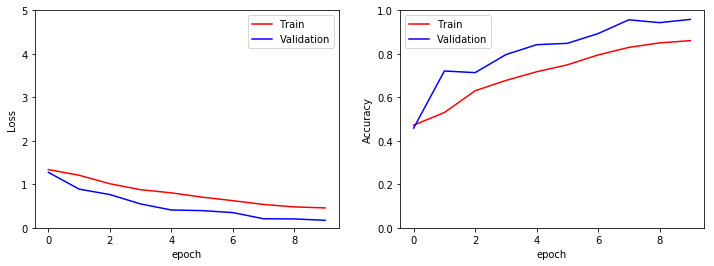

In [65]:
plot_results(res)

In [67]:
validateData.head(2)

,image_path,label,labels_num
1313,./trafficsigns_shapedata/triangle/00874_00000.png,triangle,3
1674,./trafficsigns_shapedata/triangle/00201_00002.png,triangle,3


In [68]:
#Prediction below

In [69]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

# Here the validation is used for testing and this should be changes to a separate test set.
test_generator = test_datagen.flow_from_dataframe(
        dataframe=validateData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical',
shuffle = False)


Found 730 validated image filenames belonging to 5 classes.


In [70]:
validateData

,image_path,label,labels_num
1313,./trafficsigns_shapedata/triangle/00874_00000.png,triangle,3
1674,./trafficsigns_shapedata/triangle/00201_00002.png,triangle,3
229,./trafficsigns_shapedata/square/00033_00002.png,square,0
2974,./trafficsigns_shapedata/round/01901_00000.png,round,4
2222,./trafficsigns_shapedata/round/01956_00000.png,round,4
807,./trafficsigns_shapedata/diamond/01109_00002.png,diamond,1
761,./trafficsigns_shapedata/diamond/01502_00002.png,diamond,1
2655,./trafficsigns_shapedata/round/01066_00001.png,round,4
736,./trafficsigns_shapedata/diamond/00111_00000.png,diamond,1
2969,./trafficsigns_shapedata/round/01119_00000.png,round,4


{0: 'diamond', 1: 'hex', 2: 'round', 3: 'square', 4: 'triangle'}
[[8.5144240e-01 1.8435486e-03 1.4064282e-01 6.8210647e-04 5.3891568e-03]]
[[1. 0. 0. 0. 0.]]
[[9.9573106e-01 2.7732131e-05 4.2407061e-03 1.6042810e-07 4.0548520e-07]]
[[1. 0. 0. 0. 0.]]
[[3.6607025e-06 2.0521290e-03 9.9714416e-01 6.5511186e-04 1.4489501e-04]]
[[0. 0. 1. 0. 0.]]
[[9.0449220e-01 1.1761864e-03 9.3970649e-02 1.6157348e-04 1.9943196e-04]]
[[1. 0. 0. 0. 0.]]
[[3.4277796e-06 5.4075586e-04 9.9935490e-01 7.5974793e-05 2.4850679e-05]]
[[0. 0. 1. 0. 0.]]


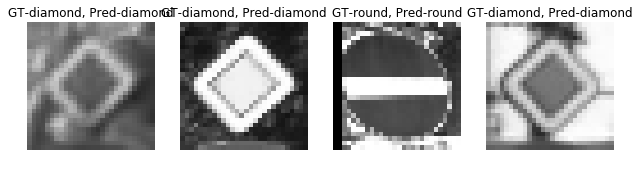

In [72]:
labels = (test_generator.class_indices)

d_inv = {v: k for k, v in labels.items()}
print (d_inv)
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_cnn.predict(x, verbose=0)
        print(y_hat)
        print(y)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,6,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

round


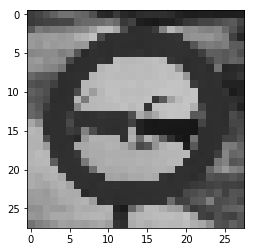

In [45]:

d_inv = {v: k for k, v in labels.items()}

for x,y in test_generator:
    temp = np.squeeze(x)
    t = d_inv[np.argmax(y)]
    print (t)
    plt.imshow(temp)
    plt.show()
    break

In [24]:
test_generator.filenames

['./trafficsigns_shapedata/triangle/00874_00000.png',
 './trafficsigns_shapedata/triangle/00201_00002.png',
 './trafficsigns_shapedata/square/00033_00002.png',
 './trafficsigns_shapedata/round/01901_00000.png',
 './trafficsigns_shapedata/round/01956_00000.png',
 './trafficsigns_shapedata/diamond/01109_00002.png',
 './trafficsigns_shapedata/diamond/01502_00002.png',
 './trafficsigns_shapedata/round/01066_00001.png',
 './trafficsigns_shapedata/diamond/00111_00000.png',
 './trafficsigns_shapedata/round/01119_00000.png',
 './trafficsigns_shapedata/triangle/01780_00001.png',
 './trafficsigns_shapedata/round/00345_00000.png',
 './trafficsigns_shapedata/triangle/00876_00001.png',
 './trafficsigns_shapedata/square/01658_00002.png',
 './trafficsigns_shapedata/round/00765_00000.png',
 './trafficsigns_shapedata/triangle/00920_00002.png',
 './trafficsigns_shapedata/round/01246_00001.png',
 './trafficsigns_shapedata/triangle/00257_00000.png',
 './trafficsigns_shapedata/round/01208_00003.png',
 './t